_Last Updated: 06/21/2021_

In [1]:
import gurobipy as gp
from gurobipy import GRB, abs_
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import json
%matplotlib inline

In [2]:
x = np.array([[0,0],[0,1], [1,0], [1,1]])
y = np.array([0,1,1,0])

### Langrangian Relaxation Subproblems

In [3]:
N = y.shape[0]
D = x[0].shape[0] # dimension of data
K = 2 # Number of units in each hidden layer
L = 3 # Number of hidden layers

w_ub, w_lb, b_ub, b_lb = [1,-1,1,-1]
epsilon = 0.01

In [4]:
def zeta_0(λ):

    # Create a new model
    m = gp.Model("0-th layer")
    
    # Create variables
    
    alpha = {}
    beta = {}
    h = {}

    for k in range(K):
        beta[(k,0)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,0)))
        for d in range(D):
            alpha[(d,k,0)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((d,k,0)))
            
        for n in range(N):
            h[(n,k,0)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k,0)))
            
    # Set objective

    m.setObjective( 
        sum( sum( sum( -λ[(n,k_prime,k,1)]*h[(n,k_prime,0)] 
                      for k in range(K)) for k_prime in range(K)) for n in range(N)), GRB.MINIMIZE)
        
   # Add constraints 
    
    for n in range(N):
        for k in range(K):
            m.addConstr(sum(alpha[(d,k,0)]*x[n,d] for d in range(D)) + beta[(k,0)] 
                        <= (D*w_ub+b_ub + epsilon)*h[(n,k,0)], name="C1 Binary Neuron "+str((n,k,0)))
            
            m.addConstr(sum(alpha[(d,k,0)]*x[n,d] for d in range(D)) + beta[(k,0)] 
                        >= epsilon + (D*w_lb+b_lb - epsilon)*(1-h[(n,k,0)]), name="C2 Binary Neuron "+str((n,k,0)))
            
    # Optimize
    
    m.setParam('OutputFlag', 0) # uncomment to silence the output
    m.optimize()
    m.printQuality()
            
    for v in m.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output[v.varName] = v.x 

#     print('Obj: %g' % m.objVal)
    
    return(m.objVal)


In [5]:
def zeta_l(layer, λ):
    
    # Create a new model
    m = gp.Model("l-th layer")
    
    l = layer # layer to be solved for
    
    # Create variables

    alpha = {}
    beta = {}
    z = {}
    h = {}
    g = {}
    
    for k in range(K):
        for n in range(N):
            for k_prime in range(K):
                z[(n,k_prime,k,l)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k_prime,k,l)))
                g[(n,k_prime,k,l)] = m.addVar(vtype=GRB.BINARY, name="g"+str((n,k_prime,k,l)))
                
            h[(n,k,l)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k,l)))
        
        for k_prime in range(K):
            alpha[(k_prime,k,l)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime,k,l)))
        
        beta[(k,l)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,l)))
        
    # Set objective
        
    m.setObjective( sum( sum( sum( λ[(n,k_prime,k,l)]*g[(n,k_prime,k,l)] 
                                 - λ[(n,k_prime,k,l+1)]*h[(n,k_prime,l)] 
                                 for k in range(K)) for k_prime in range(K)) for n in range(N)) ,GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        for k in range(K):
            m.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + beta[(k,l)] 
                        <= (K*w_ub+b_ub + epsilon)*h[(n,k,l)], name="C1 Binary Neuron "+str((n,k,l))) 

            m.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + beta[(k,l)] 
                        >= epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,l)]), name="C2 Binary Neuron "+str((n,k,l)))
            
            for k_prime in range(K):
                m.addConstr(z[(n,k_prime,k,l)] <= alpha[(k_prime,k,l)] + (-w_lb)*(1-g[(n,k_prime,k,l)]), 
                            name="z-alpha Upper Bound "+str((n,k_prime,k,l)))
                m.addConstr(z[(n,k_prime,k,l)] >= alpha[(k_prime,k,l)] + (-w_ub)*(1-g[(n,k_prime,k,l)]), 
                            name="z-alpha Lower Bound"+str((n,k_prime,k,l)))
                m.addConstr(z[(n,k_prime,k,l)] <= (w_ub)*g[(n,k_prime,k,l)], name = "z-g Upper Bound"+str((n,k_prime,k,l)))
                m.addConstr(z[(n,k_prime,k,l)] >= (w_lb)*g[(n,k_prime,k,l)], name = "z-g Lower Bound"+str((n,k_prime,k,l)))
                
    # Optimize
    
    m.setParam('OutputFlag', 0) # uncomment to silence the output
    m.optimize()
    m.printQuality()
            
    for v in m.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output[v.varName] = v.x 

#     print('Obj: %g' % m.objVal)
    
    return(m.objVal)


In [6]:
def zeta_penultimate_L(λ):
    
    # Create a new model
    m = gp.Model("(L-1)st layer")
    
    # Create variables

    alpha = {}
    beta = {}
    z = {}
    h = {}
    g = {}
    
    for k in range(K):
        for n in range(N):
            for k_prime in range(K):
                z[(n,k_prime,k,L-1)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k_prime,k,L-1)))
                g[(n,k_prime,k,L-1)] = m.addVar(vtype=GRB.BINARY, name="g"+str((n,k_prime,k,L-1)))
                
            h[(n,k,L-1)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k,L-1)))
        
        for k_prime in range(K):
            alpha[(k_prime,k,L-1)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime,k,L-1)))
        
        beta[(k,L-1)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,L-1)))
        
    # Set objective
        
    m.setObjective( sum( sum( sum( λ[(n,k_prime,k,L-1)]*g[(n,k_prime,k,L-1)] for k in range(K))
                             - λ[(n,k_prime,0,L)]*h[(n,k_prime,L-1)] 
                             for k_prime in range(K)) for n in range(N))
                   ,GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        for k in range(K):
            m.addConstr(sum(z[(n,k_prime,k,L-1)] for k_prime in range(K)) + beta[(k,L-1)] 
                        <= (K*w_ub+b_ub + epsilon)*h[(n,k,L-1)], name="C1 Binary Neuron "+str((n,k,L-1))) 

            m.addConstr(sum(z[(n,k_prime,k,L-1)] for k_prime in range(K)) + beta[(k,L-1)] 
                        >= epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,L-1)]), name="C2 Binary Neuron "+str((n,k,L-1)))
            
            for k_prime in range(K):
                m.addConstr(z[(n,k_prime,k,L-1)] <= alpha[(k_prime,k,L-1)] + (-w_lb)*(1-g[(n,k_prime,k,L-1)]),
                            name="z-alpha Upper Bound "+str((n,k_prime,k,L-1)))
                m.addConstr(z[(n,k_prime,k,L-1)] >= alpha[(k_prime,k,L-1)] + (-w_ub)*(1-g[(n,k_prime,k,L-1)]), 
                            name="z-alpha Lower Bound"+str((n,k_prime,k,L-1)))
                m.addConstr(z[(n,k_prime,k,L-1)] <= (w_ub)*g[(n,k_prime,k,L-1)], name = "z-g Upper Bound"+str((n,k_prime,k,L-1)))
                m.addConstr(z[(n,k_prime,k,L-1)] >= (w_lb)*g[(n,k_prime,k,L-1)], name = "z-g Lower Bound"+str((n,k_prime,k,L-1)))
                
    # Optimize
    
    m.setParam('OutputFlag', 0) # uncomment to silence the output
    m.optimize()
    m.printQuality()
            
    for v in m.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output[v.varName] = v.x 

#     print('Obj: %g' % m.objVal)
    
    return(m.objVal)


In [7]:
def zeta_L(λ):
    
    # Create a new model
    m = gp.Model("L-th layer")
        
    # Create variables
    
    alpha = {}
    beta = {}
    z = {}
    g = {}
    y_hat = {}
    loss = {}
    
    for n in range(N):
        
        y_hat[n] = m.addVar(vtype=GRB.BINARY, name="y_hat"+str(n))
        loss[n] = m.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name="loss"+str(n))
        
        for k_prime in range(K):
            z[(n,k_prime,0,L)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="z"+str((n,k_prime,0,L)))
            g[(n,k_prime,0,L)] = m.addVar(vtype=GRB.BINARY, name="g"+str((n,k_prime,0,L)))
            
    beta[(0,L)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((0,L)))
    
    for k_prime in range(K):
        alpha[(k_prime,0,L)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime,0,L)))
            
    # Set objective
    
    m.setObjective( sum( loss[n] 
                        + sum( λ[(n,k_prime,0,L)]*g[(n,k_prime,0,L)] for k_prime in range(K))
                       for n in range(N)) ,GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        m.addConstr(sum(z[(n,k_prime,0,L)] for k_prime in range(K)) + beta[(0,L)] 
                    <= ((K*w_ub)+b_ub + epsilon)*y_hat[n], name="C1 Binary Neuron "+str((n,0,L))) 

        m.addConstr(sum(z[(n,k_prime,0,L)] for k_prime in range(K)) + beta[(0,L)] 
                    >= epsilon + ((K*w_lb)+b_lb - epsilon)*(1-y_hat[n]), name="C2 Binary Neuron "+str((n,0,L)))
        
        m.addConstr(loss[n] >= y[n] - y_hat[n], name = "C1 Loss Function"+str(n))
        m.addConstr(loss[n] >= -y[n] + y_hat[n], name = "C2 Loss Function"+str(n))
        
        for k_prime in range(K):
            m.addConstr(z[(n,k_prime,0,L)] <= alpha[(k_prime,0,L)]+ w_ub*(1-g[(n,k_prime,0,L)]),
                        name="z-alpha Upper Bound "+str((n,k_prime,0,L)))
            m.addConstr(z[(n,k_prime,0,L)] - alpha[(k_prime,0,L)] >= (-w_ub)*(1-g[(n,k_prime,0,L)]), 
                            name="z-alpha Lower Bound"+str((n,k_prime,0,L)))
            m.addConstr(z[(n,k_prime,0,L)] <= (w_ub)*g[(n,k_prime,0,L)], name = "z-g Upper Bound"+str((n,k_prime,0,L)))
            m.addConstr(z[(n,k_prime,0,L)] >= (w_lb)*g[(n,k_prime,0,L)], name = "z-g Lower Bound"+str((n,k_prime,0,L)))
                            
    # Optimize
    
    m.setParam('OutputFlag', 0) # uncomment to silence the output
    m.optimize()
    m.printQuality()
            
    for v in m.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output[v.varName] = v.x 

#     print('Obj: %g' % m.objVal)
    
    return(m.objVal)


### Solving the dual with the Subgradient algorithm

In [8]:

# λ_norm_tracker = []
# for i in range(100):

    ## initialize langrange multiplier

λ = {} 

np.random.seed(6)

for n in range(N):
    for k_prime in range(K):
        for k in range(K):
            for l in range(1,L):
                λ[(n,k_prime,k,l)] = np.random.uniform(low=-100, high=100)
        λ[(n,k_prime,0,L)] = np.random.uniform(low=-100, high=100)

λ_array = list(λ.values())        

output = {} # dictionary of outputs

    ## Solve subproblems and find the dual objective

dual_obj = zeta_0(λ) + sum(zeta_l(l,λ) for l in range(1,L-1)) + zeta_penultimate_L(λ) + zeta_L(λ) 

    ## Find the subgradient vector at λ

s = {}

for n in range(N):
    for k_prime in range(K):
        for k in range(K):
            for l in range(1,L):
                s[(n,k_prime,k,l)] = output['g'+str((n,k_prime,k,l))] - output['h'+str((n,k_prime,l-1))]
        s[(n,k_prime,0,L)] = output['g'+str((n,k_prime,0,L))] - output['h'+str((n,k_prime,L-1))]

s_array = np.array(list(s.values()))

    ## Simple Stepsize

# gamma = 1

    ## Adaptive Stepsize

mu_naught = 2
mu = mu_naught

Z_best = 0 # Lower bound on primal

gamma = mu*((Z_best - dual_obj)/(np.linalg.norm(s_array))**2)

    ## Track the projected subgradinet

indicator = []

for i in range(len(λ_array)):
    if (λ_array[i] + gamma*s_array[i]) > 0:
        indicator.append(1)
    else:
        indicator.append(0)

indicator = np.array(indicator)
projected_s = indicator.T*s_array

#     if (dual_obj >= -1e-6) and (dual_obj_tracker[t]-dual_obj_tracker[t-1] < 1e-6):
#         print("The dual objective roughly optimal")
#     else:
#         print("Proceed with the subgradient algorithm")

subgradient_tracker = [np.linalg.norm(s_array)]
dual_obj_tracker = [dual_obj]
gamma_tracker = [gamma]
projected_s_tracker = [np.linalg.norm(projected_s)]
mu_tracker = [mu]

adapt_param_factor = 2/3 # try 1/4 and 2/3

T = 0 # Number of times Z_{D} did not increase


for t in range(1,1000): 

    if t%100 == 0:
        print("Iteration count:", t)

        ## Update λ

    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L):
                    λ[(n,k_prime,k,l)] = λ[(n,k_prime,k,l)] + gamma*s[(n,k_prime,k,l)]
            λ[(n,k_prime,0,L)] = λ[(n,k_prime,0,L)] + gamma*s[(n,k_prime,0,L)]

    λ_array = np.array(list(λ.values()))

        ## Solve subproblems and find the dual objective

    dual_obj = zeta_0(λ) + sum(zeta_l(l,λ) for l in range(1,L-1)) + zeta_penultimate_L(λ) + zeta_L(λ) 

    dual_obj_tracker.append(dual_obj)

        ## Find the subgradient vector at λ

    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L):
                    s[(n,k_prime,k,l)] = output['g'+str((n,k_prime,k,l))] - output['h'+str((n,k_prime,l-1))]
            s[(n,k_prime,0,L)] = output['g'+str((n,k_prime,0,L))] - output['h'+str((n,k_prime,L-1))]

    s_array = np.array(list(s.values()))
    subgradient_tracker.append(np.linalg.norm(s_array))

        ## Simple step-size

#     gamma = 1/np.sqrt(t) 

        ## Adaptive Polyak Stepsize

    if dual_obj > Z_best:
        Z_best = dual_obj

    if not (dual_obj > dual_obj_tracker[-2]):
        T += 1
    else:
        T = 0

    if T >= 2: # scaling mu if Z_{D} did not increase in the last 2 iterations
        mu = adapt_param_factor*mu

    mu_tracker.append(mu)

    gamma = mu*((Z_best - dual_obj)/(np.linalg.norm(s_array))**2)
    gamma_tracker.append(gamma)

        ## Track norm of projected subgradinet

    indicator = []

    for i in range(len(λ_array)):
        if (λ_array[i] + gamma*s_array[i]) < 0:
            indicator.append(0)
        else:
            indicator.append(1)

    indicator = np.array(indicator)
    projected_s = indicator.T*s_array

    projected_s_tracker.append(np.linalg.norm(projected_s))

    if (dual_obj >= -1e-5) and (dual_obj_tracker[t]-dual_obj_tracker[t-1] < 1e-6):
        break

#         The lower bound on the primal might not always be 0, but should be??

# assert all((x <= 1e-8 and x >= -1e-8) for x in λ_array*s_array), "Complementary Slackness Conditions are not upheld"

#     λ_norm_tracker.append(np.linalg.norm(λ_array))
    
# λ_norm_tracker


Academic license - for non-commercial use only - expires 2021-07-16
Using license file /Library/gurobi911/gurobi.lic
Iteration count: 100


###  Plot Dual Objective and Subgradient figures

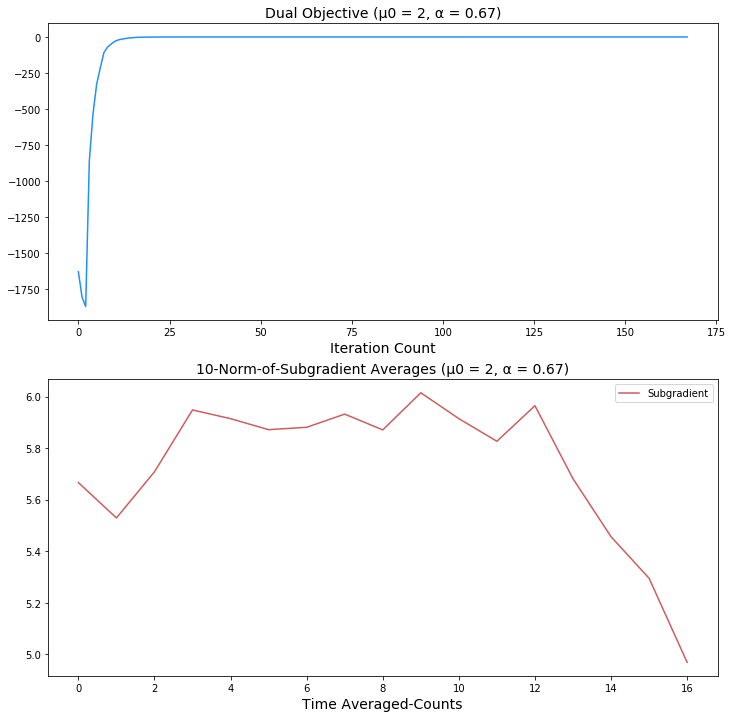

In [9]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(12, 12)

subgrad_y1 = [np.mean(subgradient_tracker[i:i+10]) for i in range(0,len(subgradient_tracker),10)]
# subgrad_y2 = [np.mean(projected_s_tracker[i:i+10]) for i in range(0,len(projected_s_tracker),10)]

ax1.plot([x for x in range(t+1)], dual_obj_tracker, c="dodgerblue")
ax2.plot([x for x in range(len(subgrad_y1))], subgrad_y1, c="indianred")
# ax2.plot([x for x in range(len(projected_s_tracker))], projected_s_tracker, c="dodgerblue")

ax1.set_title("Dual Objective (μ0 = {}, α = {})".format(np.round(mu_naught,2), np.round(adapt_param_factor,2)), fontsize=14)
ax2.set_title("10-Norm-of-Subgradient Averages (μ0 = {}, α = {})".format(np.round(mu_naught,2), np.round(adapt_param_factor,2)), fontsize=14)

ax2.legend(["Subgradient", "Projected Subgradient"])

ax1.set_xlabel('Iteration Count', fontsize=14)
ax2.set_xlabel('Time Averaged-Counts', fontsize=14)

# filename = 'mu0={} alpha={}.png'.format(np.round(mu_naught,2), np.round(adapt_param_factor,2))
# plt.savefig("Subgradient Plots/"+filename)

None

In [10]:
dual_obj

-8.251000245666859e-06

In [11]:
# # z-g-h-λ Table Maker

# index_list = []
# z_list = []
# g_list = []
# h_list = []
# λ_list = []

# for n in range(N):
#     for k_prime in range(K):
#         for k in range(K):
#             for l in range(1,L):
#                 index_list.append((n,k_prime,k,l))
#                 z_list.append(output['z'+str((n,k_prime,k,l))])
#                 g_list.append(output['g'+str((n,k_prime,k,l))])
#                 h_list.append(output['h'+str((n,k_prime,l-1))])
#                 λ_list.append(λ[(n,k_prime,k,l)])
                
#         index_list.append((n,k_prime,0,L))
#         z_list.append(output['z'+str((n,k_prime,0,L))])
#         g_list.append(output['g'+str((n,k_prime,0,L))])
#         h_list.append(output['h'+str((n,k_prime,L-1))])
#         λ_list.append(λ[(n,k_prime,0,L)])
        
# z_g_h_λ_dict = {"(n,k\',k,l)":index_list, "z-values": z_list, "g-values": g_list, "h-values": h_list, "λ":λ_list}                
# df = pd.DataFrame(z_g_h_λ_dict)
# # df.to_csv("z-g-h-λ Table.csv") 
# df
                

### Primal Feasible Solution w/SGD

In [20]:
# Referred to https://gist.github.com/RichardKelley/17ef5f2291c273de11540c33dc1bfbf2
# to build the Pytorch nn
# @RichardKelley

torch.manual_seed(93)

class XorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer0 = nn.Linear(2,2)
        self.layer1 = nn.Linear(2,2)
        self.layer2 = nn.Linear(2,2)
        self.layer3 = nn.Linear(2,1)
    def forward(self, x):
        x = F.relu(self.layer0(x))
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

m = XorNet()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(m.parameters(), lr=1e-3)

training_epochs = 3000
minibatch_size = 32

# input-output pairs
pairs = [(np.asarray([0.0,0.0]), [0.0]),
         (np.asarray([0.0,1.0]), [1.0]),
         (np.asarray([1.0,0.0]), [1.0]),
         (np.asarray([1.0,1.0]), [0.0])]

state_matrix = np.vstack([x[0] for x in pairs])
label_matrix = np.vstack([x[1] for x in pairs])

# initialize weights from our dual pre-training

for k in range(K):
    for d in range(D):
        m.layer0.weight.data[k][d] = output['alpha'+str((d,k,0))]
    m.layer0.bias.data[k] = output['beta'+str((k,0))]

m.layer0.load_state_dict(m.layer0.state_dict())    
    
for k in range(K):
    for k_prime in range(K):
        m.layer1.weight.data[k][k_prime] = output['alpha'+str((k_prime,k,1))]
    m.layer1.bias.data[k] = output['beta'+str((k,1))]

m.layer1.load_state_dict(m.layer1.state_dict())    
    
for k in range(K):
    for k_prime in range(K):
        m.layer2.weight.data[k][k_prime] = output['alpha'+str((k_prime,k,2))]
    m.layer2.bias.data[k] = output['beta'+str((k,2))]

m.layer2.load_state_dict(m.layer2.state_dict())
        
for k_prime in range(K):
    m.layer3.weight.data[0][k_prime] = output['alpha'+str((k_prime,0,3))]
m.layer3.bias.data[0] = output['beta'+str((0,3))]    

m.layer3.load_state_dict(m.layer3.state_dict())

for i in range(training_epochs):
        
    for batch_ind in range(4):
        # wrap the data in variables
        minibatch_state_var = Variable(torch.Tensor(state_matrix))
        minibatch_label_var = Variable(torch.Tensor(label_matrix))
                
        # forward pass
        y_pred = m(minibatch_state_var)
        
        # compute and print loss
        loss = loss_fn(y_pred, minibatch_label_var)
        
        # reset gradients
        optimizer.zero_grad()
        
        # backwards pass
        loss.backward()
        
        # step the optimizer - update the weights
        optimizer.step()

    if i % 500 == 0:
        print(i, loss.item())
        
print("Function after training:")
print("f(0,0) = {}".format(m(Variable(torch.Tensor([0.0,0.0]).unsqueeze(0)))))
print("f(0,1) = {}".format(m(Variable(torch.Tensor([0.0,1.0]).unsqueeze(0)))))
print("f(1,0) = {}".format(m(Variable(torch.Tensor([1.0,0.0]).unsqueeze(0)))))
print("f(1,1) = {}".format(m(Variable(torch.Tensor([1.0,1.0]).unsqueeze(0)))))

0 38.51457977294922
500 0.2862238883972168
1000 0.23746521770954132
1500 0.22633832693099976
2000 0.18645845353603363
2500 4.172925400780514e-06
Function after training:
f(0,0) = tensor([[1.6689e-06]], grad_fn=<AddmmBackward>)
f(0,1) = tensor([[1.0000]], grad_fn=<AddmmBackward>)
f(1,0) = tensor([[1.0000]], grad_fn=<AddmmBackward>)
f(1,1) = tensor([[5.9605e-07]], grad_fn=<AddmmBackward>)


In [13]:
model_params = list(m.parameters())
model_params

[Parameter containing:
 tensor([[ 1.1016,  1.1016],
         [-1.0000,  0.4988]], requires_grad=True), Parameter containing:
 tensor([ 0.1721, -0.5012], requires_grad=True), Parameter containing:
 tensor([[ 0.7970,  0.6775],
         [-0.8650,  0.6828]], requires_grad=True), Parameter containing:
 tensor([-1.0941,  1.1017], requires_grad=True), Parameter containing:
 tensor([[ 1.2064,  1.0116],
         [-1.0000, -1.0000]], requires_grad=True), Parameter containing:
 tensor([ 0.4968, -1.0000], requires_grad=True), Parameter containing:
 tensor([[-1.0374,  1.0000]], requires_grad=True), Parameter containing:
 tensor([1.5154], requires_grad=True)]

In [28]:
X = torch.Tensor([[0,0], [0,1], [1,0], [1,1]])
Y = torch.Tensor([0,1,1,0]).view(-1,1)

correct_pred = 0
for n in range(N):
    h0 = torch.matmul(model_params[0].data, X[n]) + model_params[1].data
    h0[h0 <= 0] = 0
#     h0[h0 > 0] = 1
    
    h1 = torch.matmul(model_params[2].data, h0) + model_params[3].data
    h1[h1 <= 0] = 0
#     h1[h1 > 0] = 1
    
    h2 = torch.matmul(model_params[4].data, h1) + model_params[5].data
    h2[h2 <= 0] = 0
#     h2[h2 > 0] = 1
    
    y_hat = torch.matmul(model_params[6].data, h2) + model_params[7].data
    y_hat[y_hat <= 0] = 0
#     y_hat[y_hat > 0] = 1
    
    if np.round(y_hat[0],1) == Y[n].item():
        correct_pred += 1
    
    print(X[n], ": ", y_hat)

print("\nPrediction Accuracy = ", correct_pred/(N)*100, "%")

tensor([0., 0.]) :  tensor([1.6689e-06])
tensor([0., 1.]) :  tensor([1.0000])
tensor([1., 0.]) :  tensor([1.0000])
tensor([1., 1.]) :  tensor([5.9605e-07])

Prediction Accuracy =  100.0 %


### Primal Feasible Solution w/MIP 

In [15]:
def MultiLayerMIPOptimizer(init_weights): 
        
    # Create a new model
    m = gp.Model("MIP-NN")

    # Create variables
    
    alpha = {}
    beta = {}
    h = {}
    h = {}
    z = {}
    y_hat = {}
    loss = {}

    for k in range(K):
        alpha[k,0,L] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k,0,L))) 

        for d in range(D):
            alpha[(d,k,0)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((d,k,0))) 
        for k_prime in range(K):
            for l in range(1,L):
                alpha[(k_prime,k,l)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime,k,l))) 
    
        for l in range(0,L):
            beta[(k,l)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,l))) 
    
    beta[(0,L)] = m.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((0,L)))
    
    for n in range(N):

        y_hat[n] = m.addVar(vtype=GRB.BINARY, name="y_hat"+str(n))
        loss[n] = m.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name="loss"+str(n)) 
        
        for k in range(K):
            for l in range(0,L):
                h[(n,k,l)] = m.addVar(vtype=GRB.BINARY, name="h"+str((n,k,l))) 
            for k_prime in range(K):
                for l in range(1,L):
                    z[(n,k_prime,k,l)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k_prime,k,l))) 
        
            z[(n,k,0,L)] = m.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k,0,L)))
                        
    # Set objective
    m.setObjective(sum(loss[n] for n in range(N)), GRB.MINIMIZE)

    # Add constraints
        
    for n in range(N):
        m.addConstr(sum(z[(n,k_prime,0,L)] for k_prime in range(K)) + beta[(0,L)] 
                    <= ((K*w_ub)+b_ub + epsilon)*y_hat[n], name="C1 Binary Neuron "+str((n,0,L))) 

        m.addConstr(sum(z[(n,k_prime,0,L)] for k_prime in range(K)) + beta[(0,L)] 
                    >= epsilon + ((K*w_lb)+b_lb - epsilon)*(1-y_hat[n]), name="C2 Binary Neuron "+str((n,0,L)))
        
        m.addConstr(loss[n] >= y[n] - y_hat[n], name = "C1 Loss Function"+str(n))
        m.addConstr(loss[n] >= -y[n] + y_hat[n], name = "C2 Loss Function"+str(n))
        
        for k in range(K):
            m.addConstr(sum(alpha[(d,k,0)]*x[n,d] for d in range(D)) + beta[(k,0)] 
                        <= (D*w_ub+b_ub + epsilon)*h[(n,k,0)], name="C1 Binary Neuron "+str((n,k,0)))
            
            m.addConstr(sum(alpha[(d,k,0)]*x[n,d] for d in range(D)) + beta[(k,0)] 
                        >= epsilon + (D*w_lb+b_lb - epsilon)*(1-h[(n,k,0)]), name="C2 Binary Neuron "+str((n,k,0)))

            for l in range(1, L):
                m.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + beta[(k,l)] 
                            <= (K*w_ub+b_ub + epsilon)*h[(n,k,l)], name="C1 Binary Neuron "+str((n,k,l))) 
                
                # 0 NOT <= -0.01 
                
                m.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + beta[(k,l)] 
                            >= epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,l)]), name="C2 Binary Neuron "+str((n,k,l)))
                
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L):
                    m.addConstr(z[(n,k_prime,k,l)] <= alpha[(k_prime,k,l)] + (w_ub-w_lb)*(1.0-h[(n,k_prime,l-1)]), name="Explicit z-alpha Bound "+str((n,k_prime,k,l))) 
                    m.addConstr(z[(n,k_prime,k,l)] >= alpha[(k_prime,k,l)] + (w_lb-w_ub)*(1.0-h[(n,k_prime,l-1)]), name="z-alpha Bound "+str((n,k_prime,k,l))) 
                    m.addConstr(z[(n,k_prime,k,l)] <= (w_ub)*h[(n,k_prime,l-1)], name="z-0 Bound1 "+str((n,k,k_prime,l)))
                    m.addConstr(z[(n,k_prime,k,l)] >= (w_lb)*h[(n,k_prime,l-1)], name="z-0 Bound2 "+str((n,k,k_prime,l)))

            m.addConstr(z[(n,k_prime,0,L)] <= alpha[(k_prime,0,L)] + (w_ub-w_lb)*(1.0-h[(n,k_prime,L-1)]), name="Explicit z-alpha Bound "+str((n,k_prime,0,L))) 
            m.addConstr(z[(n,k_prime,0,L)] >= alpha[(k_prime,0,L)] + (w_lb-w_ub)*(1.0-h[(n,k_prime,L-1)]), name="z-alpha Bound "+str((n,k_prime,0,L))) 
            m.addConstr(z[(n,k_prime,0,L)] <= (w_ub)*h[(n,k_prime,L-1)], name="z-0 Bound1 "+str((n,k_prime,0,L)))
            m.addConstr(z[(n,k_prime,0,L)] >= (w_lb)*h[(n,k_prime,L-1)], name="z-0 Bound2 "+str((n,k_prime,0,L)))

    # Fix alphas and betas to check feasibility            
            
#     for k in range(K):
#         m.addConstr(alpha[k,0,L] == init_weights['alpha'+str((k,0,L))], name="strict1"+str((k,0,L)))

#         for d in range(D):
#             m.addConstr(alpha[(d,k,0)] == init_weights['alpha'+str((d,k,0))], name="strict2"+str((d,k,0)))
#         for k_prime in range(K):
#             for l in range(1,L):
#                 m.addConstr(alpha[(k_prime,k,l)] == init_weights['alpha'+str((k_prime,k,l))], name="strict3"+str((k_prime,k,l)))
    
#         for l in range(0,L):
#             m.addConstr(beta[(k,l)] == init_weights['beta'+str((k,l))], name="strict4"+str((k,l)))
    
#     m.addConstr(beta[(0,L)] == init_weights['beta'+str((0,L))], name="strict5")
            
    # Set initial feasible solution
    
    for k in range(K):
        alpha[k,0,L].start = init_weights['alpha'+str((k,0,L))]

        for d in range(D):
            alpha[(d,k,0)].start = init_weights['alpha'+str((d,k,0))]
        for k_prime in range(K):
            for l in range(1,L):
                alpha[(k_prime,k,l)].start = init_weights['alpha'+str((k_prime,k,l))]
    
        for l in range(0,L):
            beta[(k,l)].start = init_weights['beta'+str((k,l))]
    
    beta[(0,L)].start = init_weights['beta'+str((0,L))]
    
    # Optimize model
#     m.setParam('OutputFlag', 0)
    m.optimize()
    m.printQuality()

    output_dict = {}
    
    for v in m.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 3)))
        output_dict[v.varName] = np.round(v.x, 3)

    print('Obj: %g' % m.objVal)
    
    model_params = []
    weights = []
    biases = []
    for k in range(K):
        weights.append([output_dict['alpha'+str((d,k,0))] for d in range(D)])
        biases.append(output_dict['beta'+str((k,0))])
    model_params.append(np.array(weights))
    model_params.append(np.array(biases))
    
    for l in range(1,L):
        weights = []
        biases = []
        for k in range(K):
            weights.append([output_dict['alpha'+str((k_prime,k,l))] for k_prime in range(K)])
            biases.append(output_dict['beta'+str((k,l))])
        model_params.append(np.array(weights))
        model_params.append(np.array(biases))
    
    weights = [output_dict['alpha'+str((k_prime,0,L))] for k_prime in range(K)]
    biases = [output_dict['beta'+str((0,L))]]
    model_params.append(np.array(weights))
    model_params.append(np.array(biases))
    
    return(output_dict, model_params)



In [16]:
MIP_Var_dict, MIP_model_params = MultiLayerMIPOptimizer(output)


Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 224 rows, 93 columns and 624 nonzeros
Model fingerprint: 0xa7ab08d9
Variable types: 65 continuous, 28 integer (28 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]

User MIP start produced solution with objective 2 (0.02s)
Loaded user MIP start with objective 2

Presolve removed 8 rows and 4 columns
Presolve time: 0.00s
Presolved: 216 rows, 89 columns, 608 nonzeros
Variable types: 61 continuous, 28 integer (28 binary)

Root relaxation: objective 0.000000e+00, 47 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    4    2.00000    0.00000   100%     -    0s
H    0    

In [17]:
MIP_model_params

[array([[-1.,  1.],
        [ 1., -1.]]), array([-0.99, -0.99]), array([[-1., -1.],
        [-1., -1.]]), array([ 1., -1.]), array([[-1., -1.],
        [-1., -1.]]), array([1.  , 0.01]), array([1., 1.]), array([-1.])]

In [18]:
correct_pred = 0
for n in range(N):
    h0 = np.dot(MIP_model_params[0].data, X[n]) + MIP_model_params[1].data
    h0[h0 <= 0] = 0
    h0[h0 > 0] = 1
    
    h1 = np.dot(MIP_model_params[2].data, h0) + MIP_model_params[3].data
    h1[h1 <= 0] = 0
    h1[h1 > 0] = 1
    
    h2 = np.dot(MIP_model_params[4].data, h1) + MIP_model_params[5].data
    h2[h2 <= 0] = 0
    h2[h2 > 0] = 1
    
    y_hat = np.dot(MIP_model_params[6].data, h2) + MIP_model_params[7].data
    y_hat[y_hat <= 0] = 0
    y_hat[y_hat > 0] = 1
    
    if y_hat[0] == Y[n].item():
        correct_pred += 1
    
    print(x[n], ": ", y_hat)

print("\nPrediction Accuracy = ", correct_pred/(N)*100, "%")

[0 0] :  [0.]
[0 1] :  [1.]
[1 0] :  [1.]
[1 1] :  [0.]

Prediction Accuracy =  100.0 %


### Evaluator 

In [19]:
h = {} # tracks output of units

correct_pred = 0

for n in range(N):
    for k in range(K):
        h[(k,0)] = sum(output["alpha"+str((d,k,0))]*x[n,d] for d in range(D)) + output["beta"+str((k,0))]
#         print("Pre-activated  h[",(n,k,0),"] = ", h[(k,0)])

        if h[(k,0)] <= 0:
            h[(k,0)] = 0
        else:
            h[(k,0)] = 1
#         print("h[",(n,k,0),"] = ", h[(k,0)])

    for l in range(1,L):
        for k in range(K):
            h[(k,l)] = sum(output["alpha"+str((k_prime,k,l))]*h[(k_prime,l-1)] for k_prime in range(K)) + output["beta"+str((k,l))]
#             print("Pre-activated h[",(n,k,l),"] = ", h[(k,l)])

            if h[(k,l)] <= 0:
                h[(k,l)] = 0
            else:
                h[(k,l)] = 1
#             print("h[",(n,k,l),"] = ", h[(k,l)])

    y_hat = sum(output["alpha"+str((k_prime,0,L))]*h[(k_prime,L-1)] for k_prime in range(K)) + output["beta"+str((0,L))]
    if y_hat <= 0:
        y_hat = 0
    else:
        y_hat = 1

    if y_hat == y[n]:
        correct_pred += 1
    
    print(x[n][0], "XOR", x[n][1], "=", float(y_hat), "Should be ", float(y[n]))

print("\nPrediction Accuracy = ", correct_pred/(n+1)*100, "%")

0 XOR 0 = 0.0 Should be  0.0
0 XOR 1 = 0.0 Should be  1.0
1 XOR 0 = 0.0 Should be  1.0
1 XOR 1 = 0.0 Should be  0.0

Prediction Accuracy =  50.0 %


### Notes and Questions (15th June 2021)

* TODO for next week:

    * Find primal solution using the dual coefficients as initialized values for standard SGD (PyTorch) and our general MIP.
        * Some initial start values make the output of a unit 0. So we're in a situation where $ 0 <= -\epsilon $, which is infeasible. See seed=5
        * Removed the $ -\epsilon $ from constraint $ \displaystyle  \sum_{k\prime=0}^{K} (z_{n,k\prime,k,l}) + \beta_{k,l} \le -\epsilon + (M+\epsilon)h_{n,k,l} $ and all similar constraints to fix this 
        * **But verify with Prof. Mintz**<br><br>
        * For SGD, it looks like the initialized values don't always start at a place where we converge to a 0 loss. Depends on the seed (as is the case with SGD in general) 
        * **Seed 6 is working as a paradigm**
<br><br>        
    * Reformulate MIP and Relaxation for MNIST and find the results of the primal for SGD and the general MIP. 
        * MNIST loss function: take binary output and find difference between expected and predicted. Find max of the values in the difference; If even one of the values in the difference is 1, then we have a loss of 1.